# Stock/Index Trend Prediction using CRISP-DM Methodology

This notebook implements a complete data mining workflow following the CRISP-DM (Cross-Industry Standard Process for Data Mining) methodology to predict stock/index trends.

## Project Overview
- **Data Source**: Yahoo Finance via yfinance API
- **Time Period**: Last 10 years of historical data
- **Objective**: Predict next-day trend (up/down) using traditional ML and LSTM models
- **Models**: Random Forest, XGBoost (baseline), and LSTM (sequence-based)

## Workflow Phases
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment Considerations

## 1. Import Required Libraries

In [56]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data fetching
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Technical indicators
import ta

# Machine Learning - Traditional Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

# Deep Learning - LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore

print("All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")

All libraries imported successfully!
TensorFlow Version: 2.20.0


## 2. Configuration - Select Your Stock/Index

**Modify the ticker symbol below to analyze any stock or index:**
- Stock examples: `"AAPL"` (Apple), `"MSFT"` (Microsoft), `"GOOGL"` (Google), `"TSLA"` (Tesla)
- Index examples: `"^IXIC"` (NASDAQ), `"^GSPC"` (S&P 500), `"^DJI"` (Dow Jones), `"^FTSE"` (FTSE 100)

In [57]:
# ============================================================
# CONFIGURATION - MODIFY THESE VALUES TO ANALYZE DIFFERENT ASSETS
# ============================================================

# Ticker symbol (Yahoo Finance format)
TICKER = "^IXIC"  # Change this to any valid ticker symbol

# Display name for plots and reports (auto-detected if left as None)
TICKER_NAME = None  # Set to None for auto-detection, or specify like "NASDAQ Composite"

# Number of years of historical data to fetch
YEARS_OF_DATA = 10

# ============================================================
# Auto-detect ticker name from yfinance if not specified
# ============================================================
ticker_info = yf.Ticker(TICKER)
try:
    if TICKER_NAME is None:
        info = ticker_info.info
        TICKER_NAME = info.get('shortName') or info.get('longName') or TICKER
except Exception:
    if TICKER_NAME is None:
        TICKER_NAME = TICKER

print(f"Configuration:")
print(f"  Ticker Symbol: {TICKER}")
print(f"  Display Name: {TICKER_NAME}")
print(f"  Historical Period: {YEARS_OF_DATA} years")

Configuration:
  Ticker Symbol: ^IXIC
  Display Name: NASDAQ Composite
  Historical Period: 10 years


## 3. Data Acquisition - Fetch Historical Data

In [58]:
# Calculate date range based on configuration
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

print(f"Fetching {TICKER_NAME} ({TICKER}) data from {start_date.date()} to {end_date.date()}...")

# Download historical data
stock_data = yf.download(TICKER, start=start_date, end=end_date, progress=True)

# Assert data is not None for type checking
assert stock_data is not None, "Failed to download data from yfinance"

# Fix MultiIndex columns issue (yfinance returns MultiIndex for single tickers)
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)

print(f"\nData fetched successfully!")
print(f"Shape: {stock_data.shape}")
print(f"Date range: {stock_data.index[0]} to {stock_data.index[-1]}")
stock_data.head()

Fetching NASDAQ Composite (^IXIC) data from 2015-12-14 to 2025-12-11...


[*********************100%***********************]  1 of 1 completed


Data fetched successfully!
Shape: (2513, 5)
Date range: 2015-12-15 00:00:00 to 2025-12-11 00:00:00


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-12-15,4995.359863,5026.540039,4986.990234,4991.209961,2054710000
2015-12-16,5071.129883,5078.990234,4992.629883,5033.479980,2036610000
2015-12-17,5002.549805,5088.580078,5002.549805,5087.169922,1897220000
2015-12-18,4923.080078,4996.490234,4921.330078,4982.580078,3765210000
2015-12-21,4968.919922,4968.919922,4928.930176,4957.529785,1673400000


## 4. Data Cleaning and Preparation

In [59]:
# Check for missing values
print("Missing Values:")
print(stock_data.isnull().sum())  # type: ignore[union-attr]
print("\n" + "="*50 + "\n")

# Check data types
print("Data Types:")
print(stock_data.dtypes)  # type: ignore[union-attr]
print("\n" + "="*50 + "\n")

# Check for duplicates
print(f"Duplicate rows: {stock_data.duplicated().sum()}")  # type: ignore[union-attr]
print("\n" + "="*50 + "\n")

# Basic statistics
print("Basic Statistics:")
print(stock_data.describe())  # type: ignore[union-attr]

Missing Values:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


Data Types:
Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object


Duplicate rows: 0


Basic Statistics:
Price         Close          High           Low          Open        Volume
count   2513.000000   2513.000000   2513.000000   2513.000000  2.513000e+03
mean   11313.771504  11388.633235  11227.165412  11311.926276  4.200245e+09
std     4831.483651   4862.794661   4794.392290   4832.240474  2.921633e+09
min     4266.839844   4293.220215   4209.759766   4218.810059  7.068800e+08
25%     7261.060059   7319.580078   7205.930176   7257.770020  2.099410e+09
50%    11082.000000  11179.870117  10972.059570  11048.250000  4.149320e+09
75%    14528.330078  14632.769531  14471.379883  14539.089844  5.254180e+09
max    23958.470703  24019.990234  23764.869141  23987.289062  9.397454e+10


In [60]:
# Handle missing values (if any) - forward fill then backward fill
stock_data = stock_data.ffill().bfill()  # type: ignore[union-attr]

# Create a copy for processing
df = stock_data.copy()

# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Sort by date
df = df.sort_index()

print(f"Cleaned data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Total trading days: {len(df)}")
df.tail()

Cleaned data shape: (2513, 5)
Date range: 2015-12-15 00:00:00 to 2025-12-11 00:00:00
Total trading days: 2513


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-12-05,23578.130859,23680.029297,23506.000000,23567.769531,8248280000
2025-12-08,23545.900391,23698.929688,23455.050781,23638.220703,8533670000
2025-12-09,23576.490234,23616.460938,23449.730469,23504.609375,7192600000
2025-12-10,23654.150391,23704.080078,23435.169922,23536.000000,7987900000
2025-12-11,23593.855469,23606.701172,23308.951172,23509.218750,7395527000


## 5. Exploratory Data Analysis (EDA)

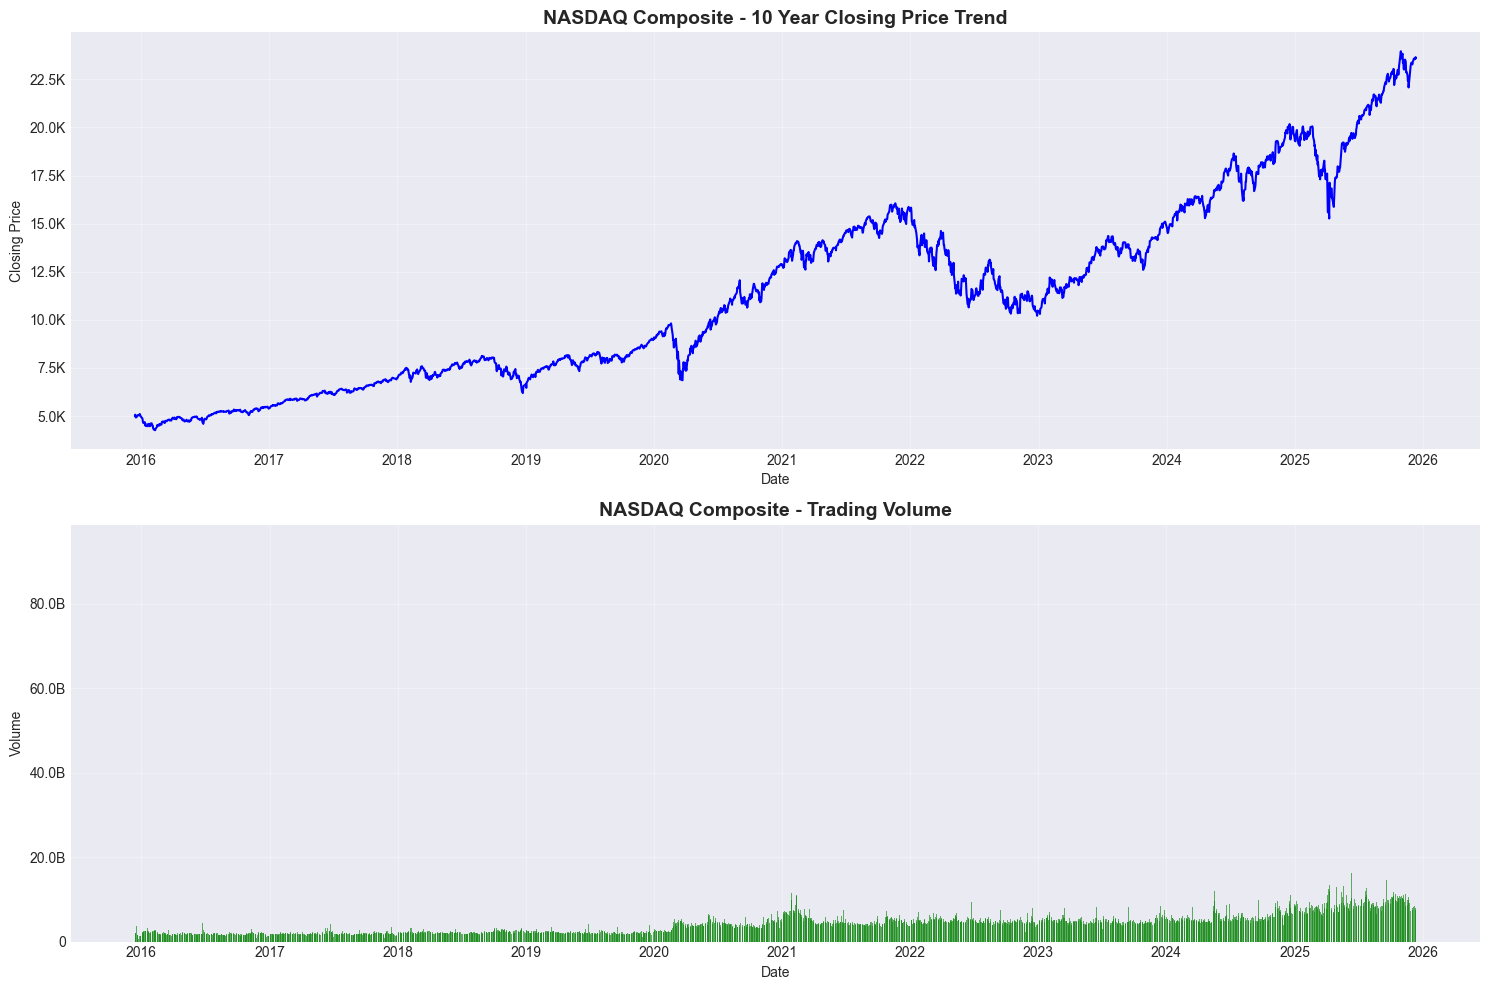

In [61]:
# Helper function to format large numbers
def format_large_number(x, pos):
    """Format large numbers with K, M, B suffixes"""
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    elif x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    else:
        return f'{x:.0f}'

from matplotlib.ticker import FuncFormatter

# Plot price trend
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Closing price
axes[0].plot(df.index, df['Close'], color='blue', linewidth=1.5)
axes[0].set_title(f'{TICKER_NAME} - {YEARS_OF_DATA} Year Closing Price Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Closing Price')
axes[0].yaxis.set_major_formatter(FuncFormatter(format_large_number))
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(df.index, df['Volume'], color='green', alpha=0.6, width=2)
axes[1].set_title(f'{TICKER_NAME} - Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].yaxis.set_major_formatter(FuncFormatter(format_large_number))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

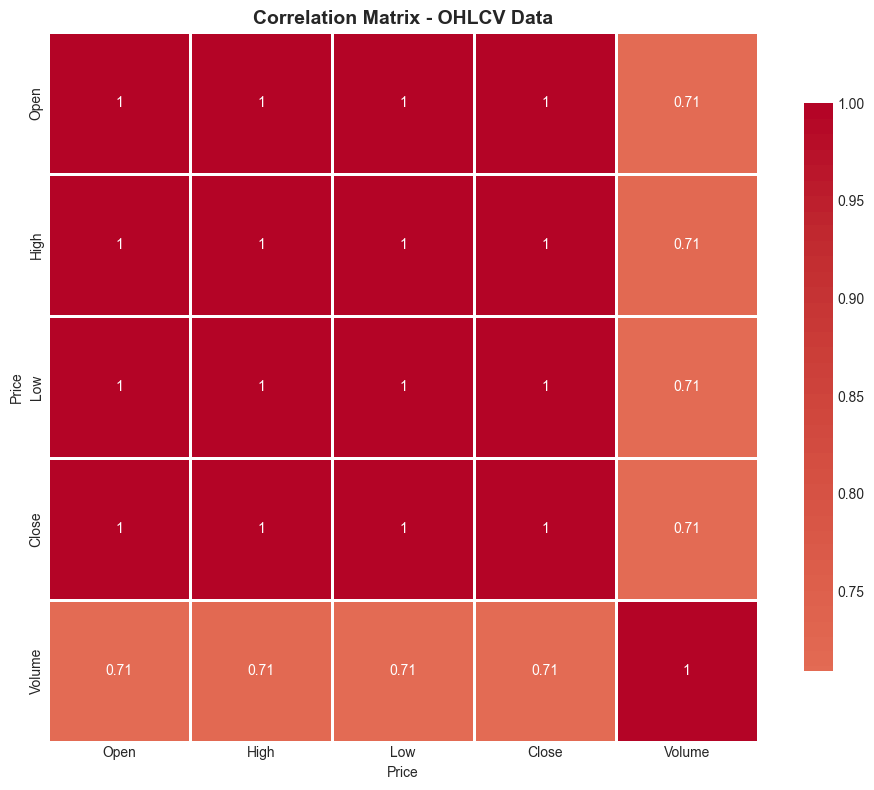

In [62]:
# Correlation heatmap
correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - OHLCV Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Feature Engineering - Technical Indicators

In [63]:
# Calculate technical indicators
print("Calculating technical indicators...")

# Daily Return (needed for features)
df['Daily_Return'] = df['Close'].pct_change()

# Moving Averages
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()  # type: ignore

# MACD
macd = ta.trend.MACD(close=df['Close'])  # type: ignore
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)  # type: ignore
df['BB_High'] = bollinger.bollinger_hband()
df['BB_Low'] = bollinger.bollinger_lband()
df['BB_Mid'] = bollinger.bollinger_mavg()

# Average True Range (ATR) - Volatility
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()  # type: ignore

# On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()  # type: ignore

# Price changes
df['Price_Change'] = df['Close'].diff()
df['Price_Change_Pct'] = df['Close'].pct_change() * 100

# Lag features (previous day's close prices)
for i in range(1, 6):
    df[f'Lag_{i}'] = df['Close'].shift(i)

print("Technical indicators calculated successfully!")
print(f"\nDataframe shape: {df.shape}")
df.tail()

Calculating technical indicators...
Technical indicators calculated successfully!

Dataframe shape: (2513, 27)


Price,Close,High,Low,Open,Volume,Daily_Return,SMA_10,SMA_20,SMA_50,EMA_10,...,BB_Mid,ATR,OBV,Price_Change,Price_Change_Pct,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-05,23578.130859,23680.029297,23506.000000,23567.769531,8248280000,0.003105,23197.800977,23046.931543,23029.658125,23278.942017,...,23046.931543,370.513886,1250826420000,72.990234,0.310529,23505.140625,23454.089844,23413.669922,23275.919922,23365.689453
2025-12-08,23545.900391,23698.929688,23455.050781,23638.220703,8533670000,-0.001367,23325.083008,23073.999609,23050.894727,23327.479903,...,23073.999609,361.468531,1242292750000,-32.230469,-0.136696,23578.130859,23505.140625,23454.089844,23413.669922,23275.919922
2025-12-09,23576.490234,23616.460938,23449.730469,23504.609375,7192600000,0.001299,23395.531055,23076.465625,23070.601523,23372.754509,...,23076.465625,347.558669,1249485350000,30.589844,0.129916,23545.900391,23578.130859,23505.140625,23454.089844,23413.669922
2025-12-10,23654.150391,23704.080078,23435.169922,23536.000000,7987900000,0.003294,23458.387109,23085.758105,23090.484336,23423.917396,...,23085.758105,341.940918,1257473250000,77.660156,0.329397,23576.490234,23545.900391,23578.130859,23505.140625,23454.089844
2025-12-11,23593.855469,23606.701172,23308.951172,23509.218750,7395527000,-0.002549,23496.303711,23095.127832,23107.258242,23454.815228,...,23095.127832,342.173654,1250077723000,-60.294922,-0.254902,23654.150391,23576.490234,23545.900391,23578.130859,23505.140625


Target Distribution (Next Day Trend):
Target
1    1411
0    1102
Name: count, dtype: int64

Percentage of Up days: 56.15%
Percentage of Down days: 43.85%


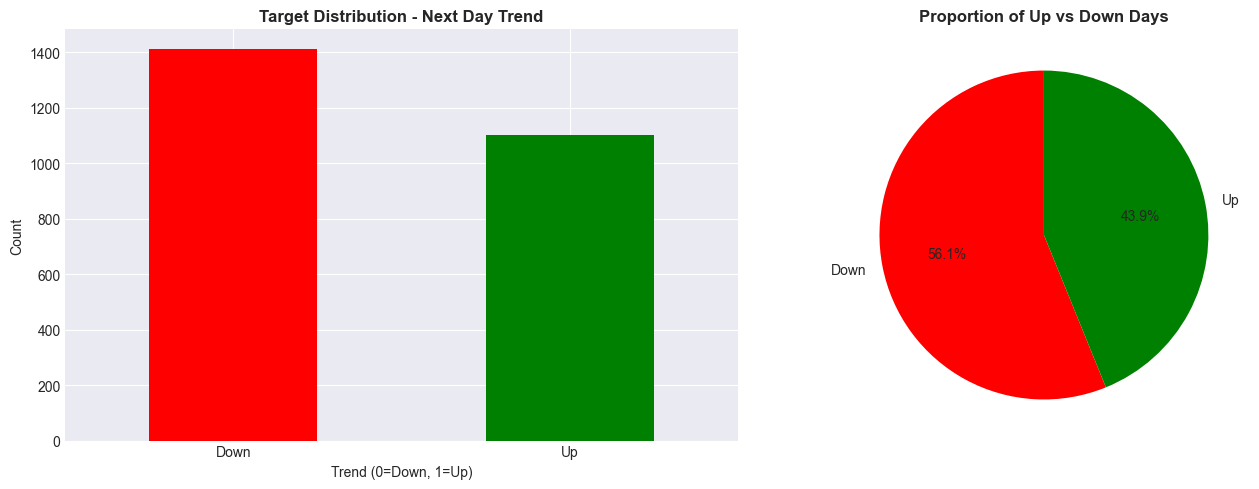

In [64]:
# Create target variable - Next day trend (1 = Up, 0 = Down)
df['Next_Day_Return'] = df['Close'].shift(-1) - df['Close']
df['Target'] = (df['Next_Day_Return'] > 0).astype(int)

# Display target distribution
print("Target Distribution (Next Day Trend):")
print(df['Target'].value_counts())
print(f"\nPercentage of Up days: {(df['Target'].sum() / len(df['Target'].dropna())) * 100:.2f}%")
print(f"Percentage of Down days: {((len(df['Target'].dropna()) - df['Target'].sum()) / len(df['Target'].dropna())) * 100:.2f}%")

# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df['Target'].value_counts().plot(kind='bar', ax=ax[0], color=['red', 'green'])
ax[0].set_title('Target Distribution - Next Day Trend', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Trend (0=Down, 1=Up)')
ax[0].set_ylabel('Count')
ax[0].set_xticklabels(['Down', 'Up'], rotation=0)

ax[1].pie(df['Target'].value_counts(), labels=['Down', 'Up'], autopct='%1.1f%%', 
          colors=['red', 'green'], startangle=90)
ax[1].set_title('Proportion of Up vs Down Days', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [65]:
# Drop NaN values created by feature engineering
df_clean = df.dropna()

print(f"Data shape after dropping NaN: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with NaN values")
print(f"\nFinal dataset ready for modeling with {len(df_clean)} samples")

Data shape after dropping NaN: (2463, 29)
Removed 50 rows with NaN values

Final dataset ready for modeling with 2463 samples


## 7. Traditional Machine Learning Models - Baseline

In [66]:
# Select features for modeling
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 
                   'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20',
                   'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
                   'BB_High', 'BB_Low', 'BB_Mid', 'ATR', 'OBV',
                   'Price_Change', 'Price_Change_Pct', 'Daily_Return',
                   'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']

X = df_clean[feature_columns]
y = df_clean['Target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {len(feature_columns)}")
print(feature_columns)

Features shape: (2463, 27)
Target shape: (2463,)

Features used: 27
['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low', 'BB_Mid', 'ATR', 'OBV', 'Price_Change', 'Price_Change_Pct', 'Daily_Return', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']


In [67]:
# Time-based train-test split (80-20 split, preserving temporal order)
split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain date range: {df_clean.index[0]} to {df_clean.index[split_index-1]}")
print(f"Test date range: {df_clean.index[split_index]} to {df_clean.index[-1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

Training set: 1970 samples
Test set: 493 samples

Train date range: 2016-02-26 00:00:00 to 2023-12-21 00:00:00
Test date range: 2023-12-22 00:00:00 to 2025-12-10 00:00:00

Features scaled successfully!


### 6.1 Random Forest Classifier

In [68]:
# Train Random Forest model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("\n" + "="*50)
print("RANDOM FOREST - MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1 Score:  {rf_f1:.4f}")
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=['Down', 'Up']))

Training Random Forest Classifier...

RANDOM FOREST - MODEL PERFORMANCE
Accuracy:  0.4260
Precision: 0.6087
Recall:    0.0486
F1 Score:  0.0900

Classification Report:
              precision    recall  f1-score   support

        Down       0.42      0.96      0.58       205
          Up       0.61      0.05      0.09       288

    accuracy                           0.43       493
   macro avg       0.51      0.50      0.34       493
weighted avg       0.53      0.43      0.29       493



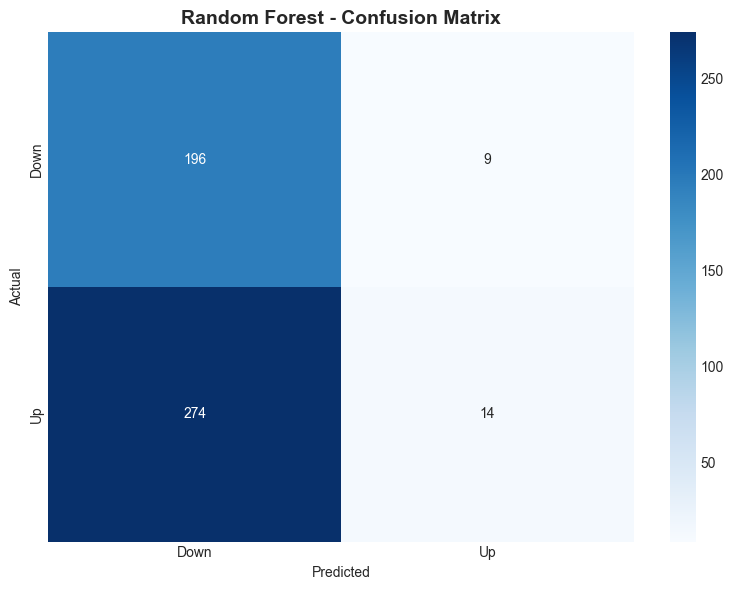

In [69]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

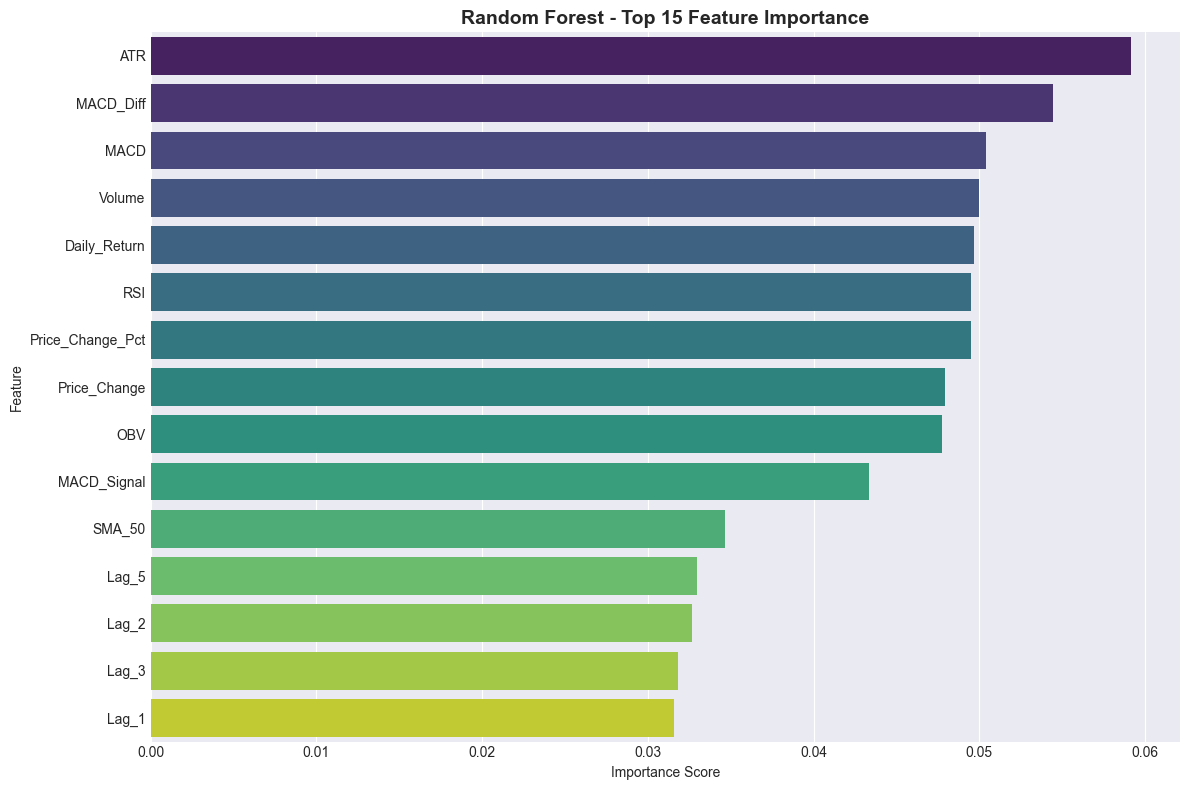


Top 10 Most Important Features:
             Feature  Importance
17               ATR    0.059156
13         MACD_Diff    0.054452
11              MACD    0.050431
4             Volume    0.050000
21      Daily_Return    0.049674
10               RSI    0.049520
20  Price_Change_Pct    0.049493
19      Price_Change    0.047922
18               OBV    0.047744
12       MACD_Signal    0.043375


In [70]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest - Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

### 6.2 XGBoost Classifier

In [71]:
# Train XGBoost model
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, 
                               random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print("\n" + "="*50)
print("XGBOOST - MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy:  {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1 Score:  {xgb_f1:.4f}")
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_xgb, target_names=['Down', 'Up']))

Training XGBoost Classifier...

XGBOOST - MODEL PERFORMANCE
Accuracy:  0.4158
Precision: 0.5000
Recall:    0.0278
F1 Score:  0.0526

Classification Report:
              precision    recall  f1-score   support

        Down       0.41      0.96      0.58       205
          Up       0.50      0.03      0.05       288

    accuracy                           0.42       493
   macro avg       0.46      0.49      0.32       493
weighted avg       0.46      0.42      0.27       493



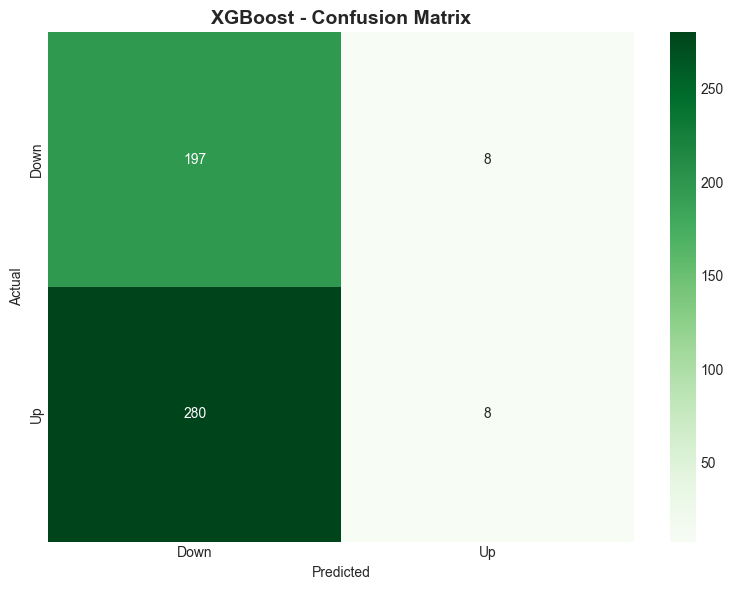

In [72]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('XGBoost - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 8. LSTM Deep Learning Model - Sequence-Based Prediction

In [73]:
# Prepare sequences for LSTM (60-day lookback window)
def create_sequences(X, y, time_steps=60):
    """
    Create sequences for LSTM training
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define sequence length
SEQUENCE_LENGTH = 60

print(f"Creating sequences with lookback window of {SEQUENCE_LENGTH} days...")

# Use scaled data for LSTM
X_scaled_full = scaler.fit_transform(X)

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled_full, y.values, SEQUENCE_LENGTH)

print(f"Sequences created: {X_sequences.shape[0]}")
print(f"Sequence shape: {X_sequences.shape}")
print(f"Target shape: {y_sequences.shape}")

Creating sequences with lookback window of 60 days...
Sequences created: 2403
Sequence shape: (2403, 60, 27)
Target shape: (2403,)


In [74]:
# Time-based train-test split for sequences (80-20 split)
split_idx = int(len(X_sequences) * 0.8)

X_train_seq = X_sequences[:split_idx]
X_test_seq = X_sequences[split_idx:]
y_train_seq = y_sequences[:split_idx]
y_test_seq = y_sequences[split_idx:]

print(f"Training sequences: {X_train_seq.shape[0]}")
print(f"Test sequences: {X_test_seq.shape[0]}")
print(f"\nTraining set shape: {X_train_seq.shape}")
print(f"Test set shape: {X_test_seq.shape}")

Training sequences: 1922
Test sequences: 481

Training set shape: (1922, 60, 27)
Test set shape: (481, 60, 27)


In [75]:
# Build LSTM model
print("Building LSTM model architecture...")

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=25, activation='relu'),
    Dropout(0.2),
    
    Dense(units=1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

Building LSTM model architecture...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,301 (223.83 KB)

 Trainable params: 57,301 (223.83 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Train LSTM model with early stopping
print("Training LSTM model...")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\nLSTM training completed!")

Training LSTM model...
Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5465 - loss: 0.6911 - val_accuracy: 0.5247 - val_loss: 0.6930
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5615 - loss: 0.6855 - val_accuracy: 0.5247 - val_loss: 0.6948
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5693 - loss: 0.6845 - val_accuracy: 0.5247 - val_loss: 0.6989
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5615 - loss: 0.6849 - val_accuracy: 0.5195 - val_loss: 0.7031
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5589 - loss: 0.6856 - val_accuracy: 0.5091 - val_loss: 0.7003
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5712 - loss: 0.6837 - val_accuracy: 0.5117 - val_loss: 0.7108
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5660 - loss: 0.6837 - val_accuracy: 0.5143 - val_loss: 0.7020
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5791 - loss: 0.6799 - v

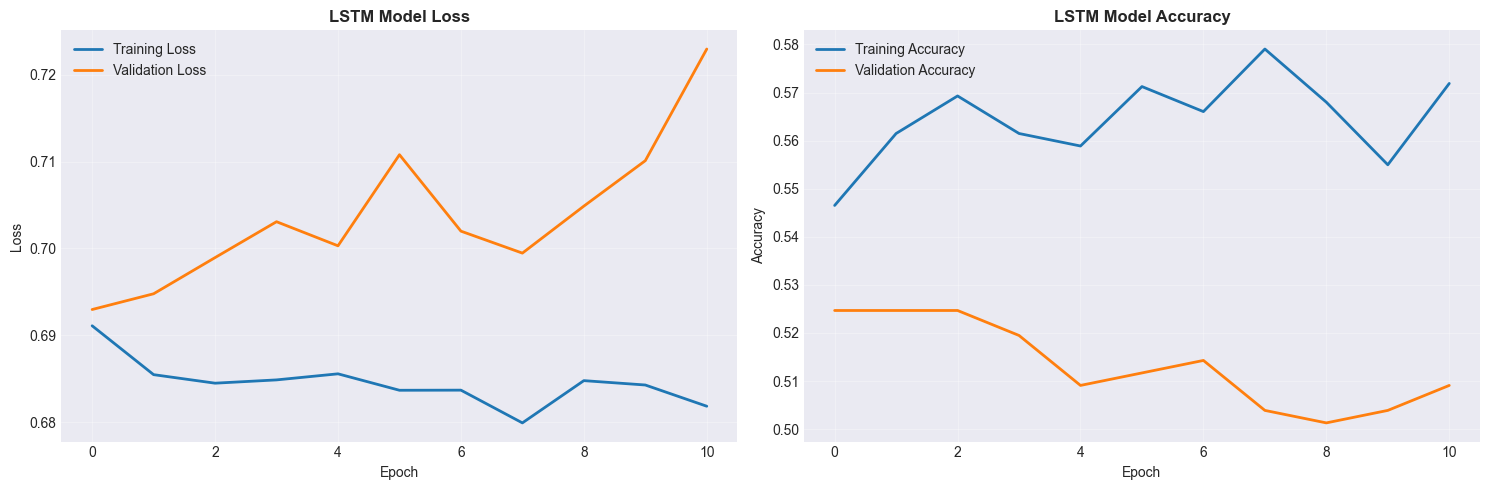

In [77]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('LSTM Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('LSTM Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
# Evaluate LSTM model on test set
print("Evaluating LSTM model...")

# Make predictions
y_pred_lstm_proba = model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()

# Calculate metrics
lstm_accuracy = accuracy_score(y_test_seq, y_pred_lstm)
lstm_precision = precision_score(y_test_seq, y_pred_lstm)
lstm_recall = recall_score(y_test_seq, y_pred_lstm)
lstm_f1 = f1_score(y_test_seq, y_pred_lstm)

print("\n" + "="*50)
print("LSTM - MODEL PERFORMANCE")
print("="*50)
print(f"Accuracy:  {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall:    {lstm_recall:.4f}")
print(f"F1 Score:  {lstm_f1:.4f}")
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test_seq, y_pred_lstm, target_names=['Down', 'Up']))

Evaluating LSTM model...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

LSTM - MODEL PERFORMANCE
Accuracy:  0.5842
Precision: 0.5842
Recall:    1.0000
F1 Score:  0.7375

Classification Report:
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00       200
          Up       0.58      1.00      0.74       281

    accuracy                           0.58       481
   macro avg       0.29      0.50      0.37       481
weighted avg       0.34      0.58      0.43       481



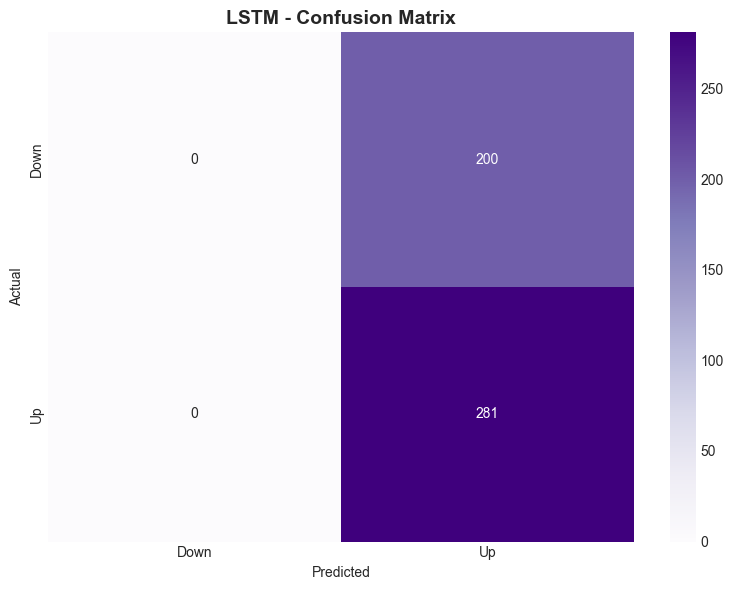

In [79]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_seq, y_pred_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title('LSTM - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 9. Model Comparison and Final Evaluation

MODEL COMPARISON - NASDAQ COMPOSITE TREND PREDICTION
        Model  Accuracy  Precision   Recall  F1 Score
Random Forest  0.425963   0.608696 0.048611  0.090032
      XGBoost  0.415822   0.500000 0.027778  0.052632
         LSTM  0.584200   0.584200 1.000000  0.737533


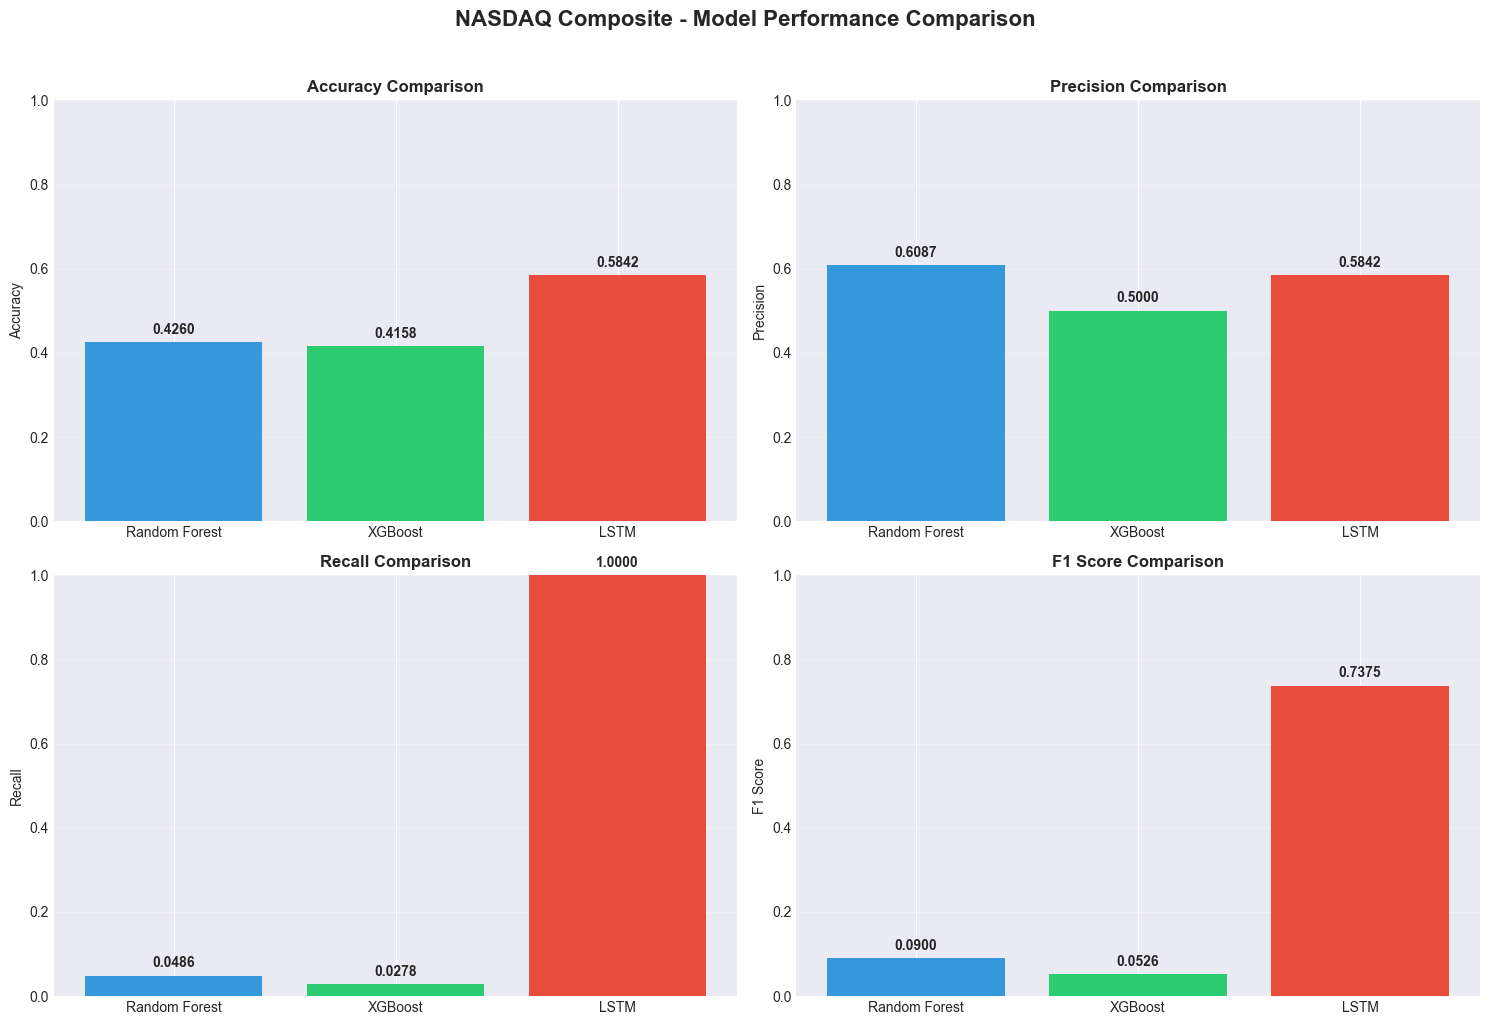

In [80]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'Accuracy': [rf_accuracy, xgb_accuracy, lstm_accuracy],
    'Precision': [rf_precision, xgb_precision, lstm_precision],
    'Recall': [rf_recall, xgb_recall, lstm_recall],
    'F1 Score': [rf_f1, xgb_f1, lstm_f1]
})

print("="*70)
print(f"MODEL COMPARISON - {str(TICKER_NAME).upper()} TREND PREDICTION")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'{TICKER_NAME} - Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].bar(comparison_df['Model'], comparison_df[metric], color=colors)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_ylim([0, 1])
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        axes[row, col].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()